Modèle TM

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
import os
import pickle
from tensorflow.keras.layers import Embedding, GRU, Dense, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive

drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/AnalyseText/fully_preprocessed_data.csv', index_col=0)


Mounted at /content/drive


Construction et entraînement du modèle LSTM

In [3]:
# Ici, je suppose que les caractéristiques (X) et les étiquettes (y) sont dans des colonnes distinctes du fichier CSV
X_data = data['texte']
y_label = data['label']

MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 1000

# Initialisez le tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(data['texte'].values)

# Convertissez les textes en séquences
X = tokenizer.texts_to_sequences(data['texte'].values)

# Mettez en forme les séquences
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)


# Divisez les données en ensembles d'entraînement et de test
X = X_data.to_numpy()
y = y_label.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Paramètres du modèle GRU
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 128
MAX_SEQUENCE_LENGTH = 1000

# Votre code existant
cv = StratifiedKFold(n_splits=5)
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)
num_classes = len(encoder.classes_)

y_train_one_hot = to_categorical(y_train_encoded, num_classes=5)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=5)

In [5]:
# Modèle LSTM
def create_model():

    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(LSTM(128))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Tokenization
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Paramètres d'entraînement
epochs = 20
batch_size = 64
print(f"X_train shape: {X_train_padded.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (5952, 1000)
y_train shape: (5952,)


In [6]:
print("Entraînement du modèle avec cross-validation...")
accuracies = []
for train_index, val_index in cv.split(X_train, y_train_encoded):

    model = create_model()
    model.fit(X_train_padded[train_index], y_train_one_hot[train_index], epochs=epochs, batch_size=batch_size)
    scores = model.evaluate(X_train_padded[val_index], y_train_one_hot[val_index])  
    accuracies.append(scores[1])

mean_accuracy = np.mean(accuracies)
print(f"Moyenne des précisions de cross-validation: {mean_accuracy:.2%}")

Entraînement du modèle avec cross-validation...
Epoch 1/20
75/75 [==============================] - 26s 261ms/step - loss: 1.4424 - accuracy: 0.4050
Epoch 2/20
75/75 [==============================] - 17s 227ms/step - loss: 0.6965 - accuracy: 0.7461
Epoch 3/20
75/75 [==============================] - 14s 188ms/step - loss: 0.2663 - accuracy: 0.9017
Epoch 4/20
75/75 [==============================] - 13s 179ms/step - loss: 0.2536 - accuracy: 0.9189
Epoch 5/20
75/75 [==============================] - 11s 146ms/step - loss: 0.1465 - accuracy: 0.9607
Epoch 6/20
75/75 [==============================] - 8s 102ms/step - loss: 0.1431 - accuracy: 0.9635
Epoch 7/20
75/75 [==============================] - 9s 125ms/step - loss: 0.0314 - accuracy: 0.9929
Epoch 8/20
75/75 [==============================] - 9s 118ms/step - loss: 0.0262 - accuracy: 0.9943
Epoch 9/20
75/75 [==============================] - 7s 96ms/step - loss: 0.0111 - accuracy: 0.9983
Epoch 10/20
75/75 [=============================

In [7]:
# Entraînement du modèle avec X_train et y_train
print("Entraînement du modèle avec X_train et y_train...")
model = create_model()
history = model.fit(X_train_padded, y_train_one_hot, epochs=epochs, batch_size=batch_size)

# Prédictions sur l'ensemble de test
print("Prédictions sur l'ensemble de test...")
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

# Calcul de l'accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test accuracy: {accuracy}")

# Calcul de la matrice de confusion normalisée
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
print("Normalized confusion matrix:")
print(conf_matrix_normalized)

model_directory = "model"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Sauvegarde du modèle
print("Sauvegarde du modèle...")
model.save_weights(f"{model_directory}/GRU_model_weights.h5")
print("Modèle sauvegardé.")

Entraînement du modèle avec X_train et y_train...
Epoch 1/20
93/93 [==============================] - 19s 183ms/step - loss: 1.3655 - accuracy: 0.4351
Epoch 2/20
93/93 [==============================] - 16s 174ms/step - loss: 0.9400 - accuracy: 0.6510
Epoch 3/20
93/93 [==============================] - 12s 131ms/step - loss: 0.4707 - accuracy: 0.8353
Epoch 4/20
93/93 [==============================] - 10s 113ms/step - loss: 0.2166 - accuracy: 0.9152
Epoch 5/20
93/93 [==============================] - 9s 98ms/step - loss: 0.1817 - accuracy: 0.9409
Epoch 6/20
93/93 [==============================] - 8s 84ms/step - loss: 0.0801 - accuracy: 0.9778
Epoch 7/20
93/93 [==============================] - 9s 95ms/step - loss: 0.0690 - accuracy: 0.9837
Epoch 8/20
93/93 [==============================] - 8s 86ms/step - loss: 0.0370 - accuracy: 0.9924
Epoch 9/20
93/93 [==============================] - 5s 57ms/step - loss: 0.0089 - accuracy: 0.9985
Epoch 10/20
93/93 [==============================] 

47/47 [==============================] - 1s 15ms/step
Accuracy sur le test : 0.946


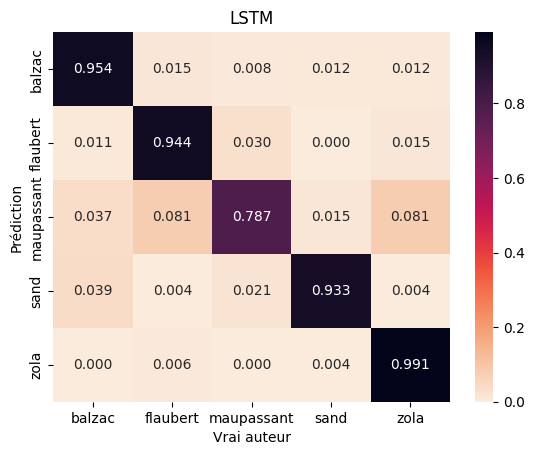

In [8]:
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcul de l'accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_classes)


# Calcul de la matrice de confusion normalisée
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

print(f"Accuracy sur le test : {accuracy:.3f}")
heatmap = sns.heatmap(conf_matrix_normalized, cmap=sns.color_palette("rocket_r", as_cmap=True), annot=True, fmt='.3f')

auteurs = ["balzac", "flaubert", "maupassant", "sand", "zola"]
# Modifiez les noms des "ticks" en abscisse et en ordonnée
heatmap.set_xticklabels(auteurs)
heatmap.set_yticklabels(auteurs)

# Modifiez les labels des axes x et y
heatmap.set_xlabel("Vrai auteur")
heatmap.set_ylabel("Prédiction")
plt.title("LSTM")
plt.show()